# Analyze Gulf of California Data: 18S and COI

Remove Chimeras; Limit by sequence length; remove contaminants; check NTC; export csv files.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
#Functions

#Raw Read Numbers
def make_rawread(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.drop('taxonomy', axis=1, inplace=True)
    df.drop('repseq', axis=1, inplace=True)
    df.set_index('OTU', inplace=True)
    return df
    
#metadata handling and sample order
def make_metadata(infile):
    df = pd.read_csv(infile)
    #make all column names with underscore
    columns_l = list(df)
    columns_l = [c.replace('-', '_') for c in columns_l]
    df.columns = columns_l
    #extract site name
    df['site'] = df['sample_name'].str.extract('([a-zA-Z0-9]+)')
    df_full = df[:]
    #add in some missing location data
    df_full.loc[df_full['site']=='UC5', 'dec_lat'] = 32
    df_full.loc[df_full['site']=='UC5', 'dec_long'] = '.118.17'
    df_full['dec_long'] = df_full['dec_long'].str.replace('^\.','-')
    df_full.set_index('sample_name', inplace=True)
    df= df[['Description', 'Treatment', 'sample_name']]
    df['comb'] = df['Description']+'_'+df['Treatment']+'_'+df['sample_name']
    df['site_Order']=df['sample_name'].str.replace('GOC2a', '16').str.replace('GOC2b', '17').str.replace('NTC', '0')
    df['site_Order']=df['site_Order'].str.extract('(\d+)')
    df.set_index('sample_name', inplace=True)
    df['site_Order']= df['site_Order'].astype(int)
    df.sort_values('site_Order', ascending=True, inplace=True)
    return df_full, df

#DESEQ Numbers
def make_deseq(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Rarefied Read Numbers (From R script); make compositional
def make_rarereads_comp(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df.T
    df['Total']=df.sum(axis=1)
    tot_reads = df['Total'].tolist()
    tot_reads = set(tot_reads)
    print('Rarefied read count:', tot_reads)
    tot_reads = df['Total'].tolist()[0]
    df = df/tot_reads *100
    df.drop('Total', axis=1, inplace=True)
    df=df.T
    return df

def make_rarereads(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Taxa table
def make_taxa(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df = df[['taxonomy', 'OTU']]
    df.set_index('OTU', inplace=True)
    df['Kingdom']=df['taxonomy'].str.split("\'").str[1]
    df['Phylum']=df['taxonomy'].str.split("\'").str[3]
    df['Class']=df['taxonomy'].str.split("\'").str[5]
    df['Order']=df['taxonomy'].str.split("\'").str[7]
    df['Family']=df['taxonomy'].str.split("\'").str[9]
    df['Genus']=df['taxonomy'].str.split("\'").str[11]
    df['Species']=df['taxonomy'].str.split("\'").str[13]
    df=df.drop('taxonomy', axis=1)
    return df

#Filtered Taxa table
def make_Ftaxa(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'OTU_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[df.columns[-7:]]
    return df

#extract sequences
def make_seq(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[['repseq']]
    return df


#from metadata file, limit OTU table and taxa table to those present in those samples
def from_metadata_to_taxareads(meta_data, otu_table, taxa_table):
    #standard M6 output; sample_names as index; OTUs as index
    cols = list(meta_data)
    otu_lim = pd.concat([meta_data, otu_table.T],join='inner', axis=1)
    otu_lim.drop(cols, inplace=True, axis=1)
    otu_lim=otu_lim.T
    otu_lim['Total']=otu_lim.sum(axis=1)
    otu_lim = otu_lim.loc[otu_lim['Total']>0]
    otu_lim.drop('Total', axis=1, inplace=True)
    cols=list(otu_lim)
    taxa_lim=pd.concat([otu_lim, taxa_table], axis=1, join='inner')
    taxa_lim.drop(cols, inplace=True, axis=1)
    return otu_lim, taxa_lim



# Import Banzai Results


In [4]:
'''#18S_M6
print('18S')
#OTU_table_taxa_all.txt location
file_loc1 = '/Users/kpitz/Projects/Gulf_of_California/processed/18S/Analysis_20180129_1419/all_lib/OTU_table_taxa_all.txt'
#metadata
meta_file = '/Users/kpitz/Projects/Gulf_of_California/processed/18S/Analysis_20180129_1419/GOC_20180129_1419_18S_analysis_metadata.csv'
#DESEQ data
#file2 = '/Users/kpitz/Projects/Gulf_of_California/Deseq/18S_GOC_DEseq_122117.csv'
#rarefied data
file3 = '/Users/kpitz/Projects/MBON/Rarefied_Data_unmerged/GOC_18S_OTU_Table_071018_M6.csv'
#Filtered OTU table
file4 = '/Users/kpitz/Projects/Gulf_of_California/processed/18S/Analysis_20180129_1419/all_lib/Filtered_OTU_taxa_table_all.csv'


raw_18S = make_rawread(file_loc1)
meta_18S, samp_lim_18S = make_metadata(meta_file)
#deseq_18S = make_deseq(file2)
rare_18S = make_rarereads(file3)
rare_comp_18S = make_rarereads_comp(file3)
taxa_18S = make_taxa(file_loc1)
Ftaxa_18S = make_Ftaxa(file4)
seq_18S = make_seq(file_loc1)'''


#COI M6
print('COI')
#OTU_table_taxa_all.txt location
file_loc1 = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Post_Blast_20190925_0914/OTU_table_taxa_all.txt'
#metadata
meta_file = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/GOC_20190921_1416_COI_analysis_metadata.csv'
#DESEQ data
#file2 = '/Users/kpitz/Projects/Gulf_of_California/Deseq/COI_GOC_DEseq_122117.csv'
#rarefied data
#file3 = '/Users/kpitz/Projects/MBON/Rarefied_Data_unmerged/GOC_COI_OTU_Table_071018_M6.csv'
#Filtered OTU table
file4 ='/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Filtered_OTU_taxa_table_all.csv'

raw_COI = make_rawread(file_loc1)
meta_COI, samp_lim_COI = make_metadata(meta_file)
#deseq_COI = make_deseq(file2)
#rare_COI = make_rarereads(file3)
#rare_comp_COI = make_rarereads_comp(file3)
taxa_COI = make_taxa(file_loc1)
Ftaxa_COI = make_Ftaxa(file4)
seq_COI = make_seq(file_loc1)

#Directory for saving Figures
plot_dir = '/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/'
plot_name = 'GOC_18SCOI_'
Plot_str = plot_dir + plot_name
print(Plot_str)

#Use to change the name of the databases
name1 = 'GOC_18SCOI_'

COI
/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_18SCOI_


# Import Chimera VSEARCH output

In [5]:
#import results of VSEARCH Chimera output
file = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Chimera_check/GOC_COI_cutadapt_chime.fasta'
name=[]
seq=[]
#names=[]
#seqs =[]
seq_dict={}
with open(file) as f:
    for strline in f:
        if strline[0]=='>':
            name = strline.strip().replace('\n','')
        else:
            seq =strline.strip().replace('\n','')
            seq_dict[name]=seq
            name=[]
            seq=[]
    
df = pd.DataFrame.from_dict(seq_dict, orient='index', columns=['seq'])
df['len']=df['seq'].str.len()
df['OTU']=df.index.str.split(';').str[0].str.replace('>','')
df.set_index('OTU', inplace=True)
df['chim'] = 'yes'
chim_MBCOI = df.copy()
print(len(df.index))
df.head()

538


,seq,len,chim
OTU,,,
DUP_304243,AAATAAATGTTGATATAGAATAGGATCTCCACCCCCCCCCACATCG...,313,yes
DUP_277532,AAATAAGTGTTGGTAAAGAATAGGGTCTCCCCCTCCACCAACATCA...,312,yes
DUP_344607,AAATAAATGTTGATACAAGATCGGATCCCCTCCCCCCCCGGCATCG...,313,yes
DUP_140232,CAATTTGGCAACCCTAGGGATCTACTTACAATTTCATGATTTTCAA...,136,yes
DUP_373670,AAAATTCACAAAATCCTTCTTATAGACCAGAAATACAAGCCAGGGT...,132,yes


# Look at sequence length of Contigs

mean 240.6072057074911
std 74.43371143637836
max 348
min 123
mean length - 1 std =  166.17349427111273


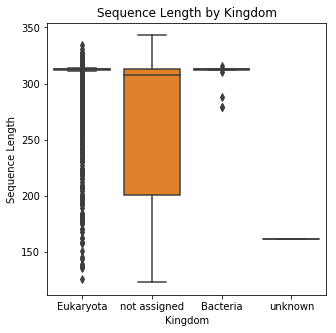

,Kingdom,Phylum,Class,Order,Family,Genus,Species,seqlen,Tot_reads
OTU,,,,,,,,,
OTU_1,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,Calanus pacificus,313,279807
OTU_2,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,Calanus pacificus,313,599556
OTU_3,Eukaryota,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Euphausia,Euphausia pacifica,313,108278
OTU_5,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus furcatus,313,94571
OTU_6,Eukaryota,Cnidaria,Hydrozoa,Siphonophorae,Athorybiidae,Athorybia,Athorybia rosacea,313,83220
OTU_7,Eukaryota,Arthropoda,Branchiopoda,Diplostraca,Sididae,g_,s_,313,97829
OTU_9,Eukaryota,Cnidaria,Hydrozoa,Siphonophorae,Agalmatidae,Halistemma,s_,313,60137
OTU_10,Eukaryota,Cnidaria,Hydrozoa,Anthoathecata,Pandeidae,Pandea,s_,313,49996
OTU_11,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Ctenocalanus,Ctenocalanus vanus,313,51991


In [6]:
#look at mean sequence length, number of reads at different sequence lengths
df = pd.concat([seq_COI, Ftaxa_COI], axis=1, join='inner')
df['seqlen'] = df['repseq'].str.len()
#get total number of reads
cols = list(raw_COI)
df=pd.concat([df, raw_COI], axis=1)
df['Tot_reads'] = df[cols].sum(axis=1)
df=df.drop(cols, axis=1)
df=df.drop('repseq', axis=1)
#print stats of sequence length
print('mean', df['seqlen'].mean())
print('std', df['seqlen'].std())
print('max', df['seqlen'].max())
print('min', df['seqlen'].min())
print('mean length - 1 std = ', df['seqlen'].mean() -df['seqlen'].std() )

#boxplot by Kingdom
import seaborn as sns
plt.figure(figsize=[5,5])
ax= sns.boxplot(data=df, y='seqlen', x='Kingdom', orient="v")
plt.title('Sequence Length by Kingdom')
plt.ylabel('Sequence Length')
plt.show()

#histogram of OTUs by sequence length

df



# How many reads are in small OTUs?

Sequence length placed into Bins
All


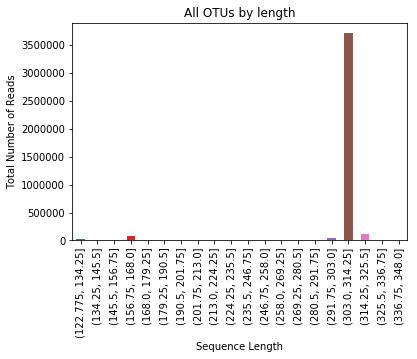

All < 300


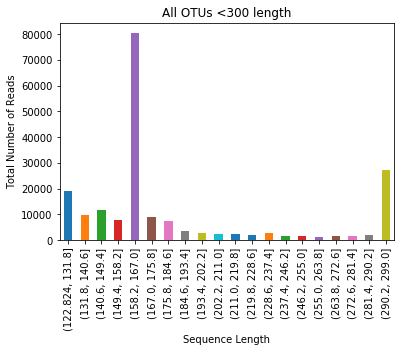

All < 166


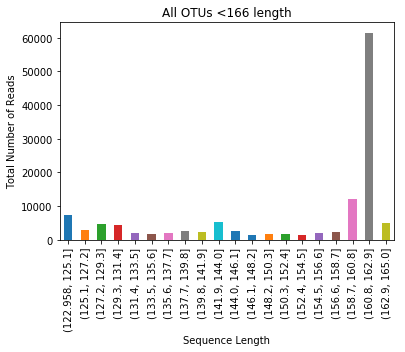

All Euk


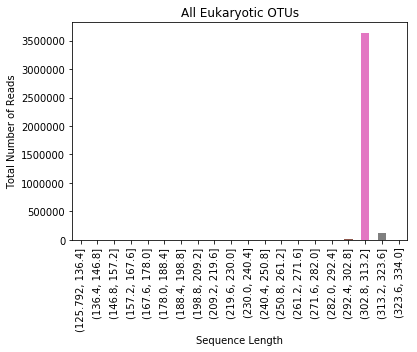

Euk 300


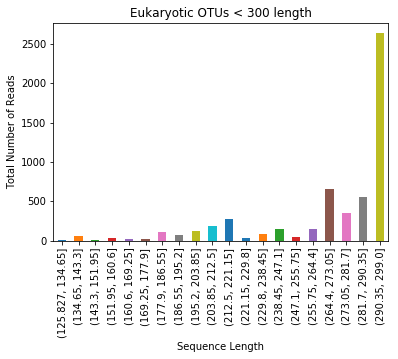

Euk 300


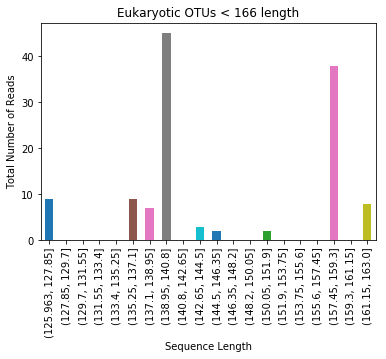

,UC1_COI,UC2_COI,UC3_COI,UC4_COI,UC5_COI,UC6_COI,UC7_COI,UC9_COI,UC10_COI,UC12_COI,...,UC15_COI,GOC2a_COI,GOC2b_COI,CP23_COI,UC3_2_COI,CP23_2_COI,UC3_1_COI,CP23_1_COI,NTC_2_COI,Total
seqlen_bins,,,,,,,,,,,,,,,,,,,,,
"(138.95, 140.8]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45
"(157.45, 159.3]",0,0,0,0,0,0,0,0,4,2,...,0,0,0,0,0,0,0,0,0,38
"(125.963, 127.85]",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,9
"(135.25, 137.1]",0,0,0,0,0,0,0,5,0,0,...,2,0,0,2,0,0,0,0,0,9
"(161.15, 163.0]",0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,6,0,0,0,0,8


In [7]:
print('Sequence length placed into Bins')
#All OTUs
print('All')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
#df=df.loc[df['seqlen']<500] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('All OTUs by length')
#print(list(df))
plt.show()
df

#All OTUs
print('All < 300')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
df=df.loc[df['seqlen']<300] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('All OTUs <300 length')
#print(list(df))
plt.show()
df

#All OTUs
print('All < 166')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
df=df.loc[df['seqlen']<166] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('All OTUs <166 length')
#print(list(df))
plt.show()
df

print('All Euk')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
#df=df.loc[df['seqlen']<500] 
df=df.loc[df['Kingdom']=='Eukaryota'] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('All Eukaryotic OTUs')
#print(list(df))
plt.show()
df

print('Euk 300')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
df=df.loc[df['seqlen']<300] 
df=df.loc[df['Kingdom']=='Eukaryota'] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('Eukaryotic OTUs < 300 length')
#print(list(df))
plt.show()
df=df.sort_values('Total',ascending=False)
df.head()

print('Euk 300')
df = pd.concat([seq_COI, taxa_COI, raw_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
df=df.loc[df['seqlen']<166] 
df=df.loc[df['Kingdom']=='Eukaryota'] 
df['seqlen_bins'] = pd.cut(df['seqlen'], 20)
df.drop('seqlen', axis=1, inplace=True)
df =df.groupby('seqlen_bins').sum()
df['Total'] = df.sum(axis=1)
#df.reset_index(inplace=True)
#df.sort_values('Total', inplace=True, ascending=False)
df.Total.plot(kind='bar')
plt.xlabel('Sequence Length')
plt.ylabel('Total Number of Reads')
plt.title('Eukaryotic OTUs < 166 length')
#print(list(df))
plt.show()
df=df.sort_values('Total',ascending=False)
df.head()

In [8]:
# look at NTC
df= pd.concat([meta_COI[['site']], raw_COI.T], axis=1)
df=df.loc[df['site']=='NTC']
df.drop('site', inplace=True, axis=1)
df=df.T
df=df.loc[df['NTC_2_COI']>0]
df=pd.concat([df, Ftaxa_COI], axis=1, join='inner')
df=df.sort_values('NTC_2_COI', ascending=False)
df


,NTC_2_COI,Kingdom,Phylum,Class,Order,Family,Genus,Species
OTU_382,1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTU_918,630,Eukaryota,Arthropoda,Insecta,Coleoptera,Staphylinidae,g_,s_
OTU_1699,351,Eukaryota,Arthropoda,Hexanauplia,Cyclopoida,Cyclopidae,Cyclops,Cyclops kikuchii
OTU_2672,316,Eukaryota,Annelida,Polychaeta,Terebellida,Terebellidae,g_,s_
OTU_1733,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTU_1734,201,Eukaryota,Arthropoda,Insecta,Hymenoptera,Braconidae,g_,s_
OTU_5270,160,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Pseudodiaptomidae,Pseudodiaptomus,Pseudodiaptomus marinus
OTU_3976,147,Eukaryota,Arthropoda,Malacostraca,Amphipoda,Caprellidae,Caprella,Caprella mutica
OTU_9280,38,Eukaryota,Ascomycota,c_,o_,f_,g_,s_
OTU_54360,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Remove control reads
df= raw_COI.copy()
controls = ['NTC_2_COI']
#get max number of reads in control samples
df['controls'] = df[controls].max(axis=1)

#subtract number of reads from environmental samples
cols = list(df)
for i in cols:
    df[i]=df[i]-df['controls']
#If negative, change to zero
df[df < 0] = 0

df.drop('controls', axis=1, inplace=True)

#remove OTUss with only 1 read
df['tot']= df.sum(axis=1)
print('Total OTUss: ',len(df.index))
df1=df.loc[df['tot']==0]
#df of removed OTUs
df1=pd.concat([df1[['tot']], Ftaxa_COI], axis=1, join='inner')
print(df1)

df=df.loc[df['tot']>1]
print('Total OTUs with >1 read: ',len(df.index))
df.drop('tot', axis=1, inplace=True)

otu_tab_filt = df.copy()
otu_tab_filt.head()


Total OTUss:  42050
            tot    Kingdom      Phylum         Class        Order  \
OTU                                                                 
OTU_382       0        NaN         NaN           NaN          NaN   
OTU_918       0  Eukaryota  Arthropoda       Insecta   Coleoptera   
OTU_1699      0  Eukaryota  Arthropoda   Hexanauplia   Cyclopoida   
OTU_1733      0        NaN         NaN           NaN          NaN   
OTU_1734      0  Eukaryota  Arthropoda       Insecta  Hymenoptera   
OTU_2672      0  Eukaryota    Annelida    Polychaeta  Terebellida   
OTU_3976      0  Eukaryota  Arthropoda  Malacostraca    Amphipoda   
OTU_5270      0  Eukaryota  Arthropoda   Hexanauplia    Calanoida   
OTU_9280      0  Eukaryota  Ascomycota            c_           o_   
OTU_54360     0        NaN         NaN           NaN          NaN   
OTU_123245    0  Eukaryota  Arthropoda   Hexanauplia   Cyclopoida   
OTU_123247    0  Eukaryota  Arthropoda   Hexanauplia   Cyclopoida   
OTU_125049    

,UC1_COI,UC2_COI,UC3_COI,UC4_COI,UC5_COI,UC6_COI,UC7_COI,UC9_COI,UC10_COI,UC12_COI,...,UC14_COI,UC15_COI,GOC2a_COI,GOC2b_COI,CP23_COI,UC3_2_COI,CP23_2_COI,UC3_1_COI,CP23_1_COI,NTC_2_COI
OTU,,,,,,,,,,,,,,,,,,,,,
OTU_1,16133,27319,56573,25109,2636,34685,19599,31821,2832,9248,...,15,1509,13,10,5,27582,8,24681,3,0
OTU_2,92204,47636,67407,38939,22886,102183,47323,76191,3751,5742,...,370,7291,40,22,131,59343,181,27718,87,0
OTU_3,46954,6398,22018,800,9624,52,3704,0,21,3,...,0,2,0,0,0,10976,0,7704,0,0
OTU_5,4731,33243,15782,7383,12114,4742,7598,365,466,195,...,79,152,58,67,0,1642,0,5708,2,0
OTU_6,0,8,0,0,0,0,0,0,0,20,...,1,0,0,0,1530,0,80407,1,1253,0


# Final Filtering and Export CSV Files

In [20]:
# Remove Chimeras and limit by sequence length
df= chim_MBCOI.copy()
df['OTU'] = df.index.str.replace('DUP_', 'OTU_')
df.set_index('OTU', inplace=True)
df=pd.concat([df[['chim']], seq_COI], axis=1)
df['seqlen'] = df['repseq'].str.len()
#remove chimeras
df=df.loc[df['chim']!='yes']
#limit by sequence length
print('max', df['seqlen'].max())
df=df.loc[df['seqlen']>=250]
df=df.loc[df['seqlen']<350]
#remove terrestrial contaminants
df=pd.concat([df[['repseq']], Ftaxa_COI], axis=1, join='inner')
df= df.loc[df['Kingdom']!='Bacteria']
df= df.loc[df['Kingdom']!='Archaea']
df= df.loc[df['Class']!='Insecta']
df= df.loc[df['Genus']!='Homo']
df= df.loc[df['Class']!='Arachnida']
df= df.loc[df['Family']!='Suidae']

print('Number of OTUs filtered by taxonomy and sequence length:', len(df.index))
#Join with otu table with removed control reads
df= pd.concat([df, otu_tab_filt], axis=1, join='inner')
print('Final Number of OTUs:', len(df.index))

samps = list(raw_COI)
levels = list(Ftaxa_COI)

#Create new otu_table, taxa_table, and sequence table
Total = df.copy()
seq_COI_filt = df[['repseq']].copy()
raw_COI_filt = df[samps].copy()
Ftaxa_COI_filt = df[levels].copy()


#get rid of '_COI' sample name string
cols = list(raw_COI_filt)
for i in range(len(cols)):
    cols[i] = cols[i].replace('_COI','')
raw_COI_filt.columns = cols
print(cols)


#export to csv files
directory = '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_'

filenames = ['seq', 'otu', 'taxa']
dfs = [seq_COI_filt, raw_COI_filt, Ftaxa_COI_filt]
for i in range(len(dfs)):
    print(directory + filenames[i] + '_table_092519.csv')
    dfs[i].to_csv(directory + filenames[i] + '_table_092519.csv')

#create Fasta File of OTUs
file = '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_Filtered_OTUs_092519.fasta'
print(file)

otus = df.index.tolist()
seqs = df['repseq'].tolist()

with open(file, "w") as f:
    for i in range(len(otus)):
        f.write('>' + otus[i])
        f.write('\n')
        f.write(seqs[i])
        f.write('\n') 

df.head()

/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



max 348
Number of OTUs filtered by taxonomy and sequence length: 21414
Final Number of OTUs: 21402
['UC1', 'UC2', 'UC3', 'UC4', 'UC5', 'UC6', 'UC7', 'UC9', 'UC10', 'UC12', 'UC13', 'UC14', 'UC15', 'GOC2a', 'GOC2b', 'CP23', 'UC3_2', 'CP23_2', 'UC3_1', 'CP23_1', 'NTC_2']
/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_seq_table_092519.csv
/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_otu_table_092519.csv
/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_taxa_table_092519.csv
/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_Filtered_OTUs_092519.fasta


,repseq,Kingdom,Phylum,Class,Order,Family,Genus,Species,UC1_COI,UC2_COI,...,UC14_COI,UC15_COI,GOC2a_COI,GOC2b_COI,CP23_COI,UC3_2_COI,CP23_2_COI,UC3_1_COI,CP23_1_COI,NTC_2_COI
OTU_1,aaataaatgttgatacagaataggatctccacccccccccacatcg...,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Calanidae,Calanus,Calanus pacificus,16133,27319,...,15,1509,13,10,5,27582,8,24681,3,0
OTU_10,gaacaagtgttggtacaggaccgggtcaccgcctcctgcaggatca...,Eukaryota,Cnidaria,Hydrozoa,Anthoathecata,Pandeidae,Pandea,s_,0,0,...,0,0,0,0,0,0,0,12837,0,0
OTU_100,aaataaatgttgatacagaatagggtctccccctccagcgggatca...,Eukaryota,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Nematoscelis,s_,62,13,...,0,0,0,0,0,10,0,5,0,0
OTU_100021,aaataggtgttgatacagaatagggtctccaccaccagcagggtcg...,Eukaryota,Mollusca,Gastropoda,unknown,Cerithiidae,g_,s_,0,0,...,0,4,0,0,0,0,0,0,0,0
OTU_100022,aaataggtgttgatacaaaataggatctcctcctcctccaacatca...,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Aetideidae,g_,s_,1,0,...,0,0,0,0,0,0,0,0,0,0
